In [1]:
import myosuite
import gym
import skvideo.io
import numpy as np
import os
import imageio
import tqdm
import time
import matplotlib.pyplot as plt
from time import sleep
import torch
import pickle
from scipy.stats import ttest_ind

MyoSuite:> Registering Myo Envs


# Environment Setup

In [2]:
env = gym.make('CenterReachOut-v0')
total_reward = 0

    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


In [3]:
def CalcAndPlotAverageRewardWithStd(policies, env, num_episodes=1000, max_timesteps=16, timestep_duration=0.05):
    time_values = np.arange(1, max_timesteps + 1) * timestep_duration
    policy_rewards = {}  # Store total episode rewards per policy

    plt.figure(figsize=(8, 6))

    for pi, label in policies:
        rewards_per_timestep = np.zeros(max_timesteps)
        rewards_squared_per_timestep = np.zeros(max_timesteps)
        total_episode_rewards = []  # Store rewards for statistical comparison

        for _ in range(num_episodes):
            obs = env.reset()
            episode_rewards = []

            for t in range(max_timesteps):
                action, _ = pi.get_action(obs)
                obs, reward, done, _ = env.step(action)
                episode_rewards.append(reward)

                if done:
                    break

            # Pad the episode_rewards list if the episode ends before max_timesteps
            episode_rewards.extend([0] * (max_timesteps - len(episode_rewards)))
            rewards_per_timestep += np.array(episode_rewards)
            rewards_squared_per_timestep += np.array(episode_rewards) ** 2

            # Store total episode reward
            total_episode_rewards.append(sum(episode_rewards))

        # Store episode rewards for statistical analysis
        policy_rewards[label] = total_episode_rewards

        # Compute the average and standard deviation per timestep
        avg_rewards_per_timestep = rewards_per_timestep / num_episodes
        variance_per_timestep = (rewards_squared_per_timestep / num_episodes) - (avg_rewards_per_timestep ** 2)
        std_dev_per_timestep = np.sqrt(variance_per_timestep)

        # Plotting the average reward line
        plt.plot(time_values, avg_rewards_per_timestep, marker='o', linestyle='-', label=label)

        # Shading the area representing one standard deviation
        plt.fill_between(time_values, avg_rewards_per_timestep - std_dev_per_timestep,
                         avg_rewards_per_timestep + std_dev_per_timestep, alpha=0.2)

    plt.title('Average Reward per Timestep Across Episodes with Standard Deviation')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform a t-test between different policies
    labels = list(policy_rewards.keys())
    if len(labels) >= 2:
        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):
                t_stat, p_value = ttest_ind(policy_rewards[labels[i]], policy_rewards[labels[j]])
                print(f"T-test between {labels[i]} and {labels[j]}: t = {t_stat:.3f}, p = {p_value:.6f}")


## RNN Model

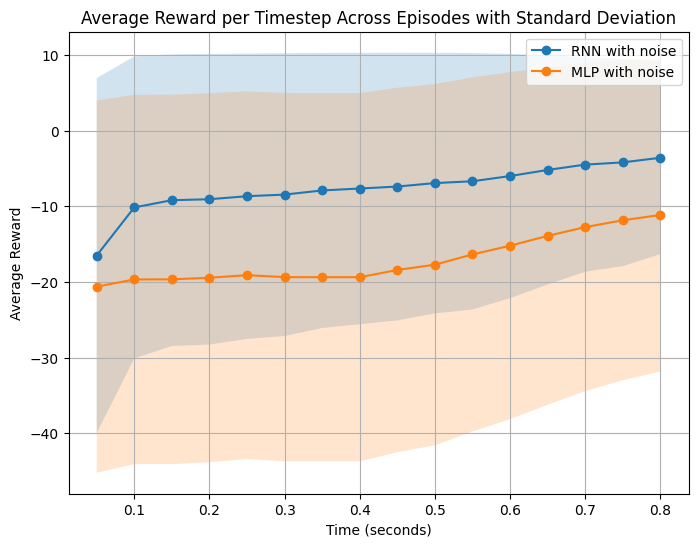

T-test between RNN with noise and MLP with noise: t = 12.358, p = 0.000000


In [10]:
RNN_without_noise_Policy = pickle.load(open("./Models/MLP_w_noise_2/iterations/best_policy.pickle", 'rb'))
RNN_with_noise_Policy = pickle.load(open("./models/RNN_w_noise/iterations/best_policy.pickle", 'rb'))

policies = [(RNN_with_noise_Policy, 'RNN with noise'), (RNN_without_noise_Policy, 'MLP with noise')]
CalcAndPlotAverageRewardWithStd(policies, env)

# MLP Model

In [ ]:
MLP_without_noise_Policy = pickle.load(open("./models/MLP_Model_2/iterations/best_policy.pickle", 'rb'))
MLP_with_noise_Policy = pickle.load(open("./models/MLP_w_noise_2/iterations/best_policy.pickle", 'rb'))

policies = [(MLP_with_noise_Policy, 'MLP with noise'), (MLP_without_noise_Policy, 'MLP without noise')]
CalcAndPlotAverageRewardWithStd(policies, env)

# Effort and Accuracy Analysis

In [ ]:
def EffortandAccuracyAnalysis(pi):
    act = 0
    reach_dist = 0
    num_actions = 0
    avg_reward = 0

    for _ in range(1000): 
            obs = env.reset()
            done = False

            for n in range(16):
                num_actions += 1
                
                action, _ = pi.get_action(obs)
                
                obs, reward, done, _ = env.step(action)

                act += np.linalg.norm(env.obs_dict['act'])
                avg_reward += reward

                
            reach_dist += np.linalg.norm(env.obs_dict['reach_err'])
            
            

    avg_act = act / 100
    avg_end_reach = reach_dist / 100
    avg_reward = avg_reward / 100
    
    return avg_act, avg_end_reach, avg_reward
  
        

            

In [ ]:
policy = "./models/MLP_w_noise/iterations/best_policy.pickle" #Change the folder to the policy location
pi = pickle.load(open(policy, 'rb'))

EffortandAccuracyAnalysis(pi)

(845.3847958747838, 1.8467019179290525, -2721.7847157574843)

In [ ]:
policy = "./models/RNN_w_noise/iterations/best_policy.pickle"  #Change the folder to the policy location
pi = pickle.load(open(policy, 'rb'))

EffortandAccuracyAnalysis(pi)

(849.3424548906878, 1.5533472297672062, -1175.6416236047014)